# Part 1. Protein-Protein Interactions in Phentypic Description Data
The purpose of this notebook is to answer the question of how networks genereated using phenotypic-text similarity based approaches through either embedding, vocabulary presence, or ontology annotation compare to or relate to networks that specify known protein-protein interactions. The hypothesis that these networks are potentially related is based on the idea that if two proteins interact, they are likely to be acting in a common pathway with a common biological function. If the phenotypic outcome of this pathway is observable and documented, then similarites between text describing the mutant phenotype for these genes may coincide with direct protein-protein interactions.

The different sections in this notebook correspond to different ways of determining if the graphs based on similarity between text descriptions, encodings of text descriptions, or annotations derived from text descriptions at all correspond to known protein-protein interactions in this dataset. The knowledge source about the protein-protein interactions for genes in this dataset is the STRING database (https://string-db.org/). The available entries in the whole dataset are subset to include only the genes that correspond to proteins that are atleast mentioned in the STRING database. This ways if a protein-protein interaction is not specified between two of the remaining genes, it is not because no interactions at all are documented either of those genes. The following cells focus on setting up a dataframe which specifies edge lists specific to each similarity method, and also a protein-protein interaction score for the genes which correspond to those two given nodes in the graphs.

In [8]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import time
import math
import sys
import gensim
import os
import warnings
import itertools
from collections import Counter, defaultdict
from inspect import signature
from scipy.stats import ks_2samp
from sklearn.metrics import precision_recall_curve, f1_score, auc

sys.path.append("../../oats")
from oats.utils.utils import save_to_pickle, load_from_pickle, merge_list_dicts, flatten
from oats.datasets.dataset import Dataset
from oats.datasets.groupings import Groupings
from oats.datasets.string import String
from oats.annotation.ontology import Ontology
from oats.annotation.annotation import write_annotations_to_tsv_file, read_annotations_from_tsv_file
from oats.graphs.pairwise import pairwise_doc2vec_onegroup, pairwise_counting_onegroup, pairwise_annotations_onegroup
from oats.graphs.pairwise import merge_edgelists, subset_edgelist_with_ids, pairwise_word2vec_onegroup
from oats.graphs.pairwise import remove_self_loops

mpl.rcParams["figure.dpi"] = 400
warnings.simplefilter('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# Nested dictionary to summarize output with shape dict[method][(tag,metric)] --> value
TAG = "protein-protein"
OUTPUT = defaultdict(dict)

### 1.1 Loading and preprocessing the dataset of genes, descriptions, and annotations

In [4]:
# Reading in the entire dataset, subsetting for Arabidopsis and all annotation types.
dataset = load_from_pickle("../data/pickles/full_dataset.pickle")
dataset.describe()
dataset.filter_by_species("ath")
dataset.collapse_by_all_gene_names()
dataset.filter_has_description()
dataset.filter_has_annotation()
dataset.describe()

Number of rows in the dataframe: 47151
Number of unique IDs:            47151
Number of unique descriptions:   16504
Number of unique gene name sets: 47151
Number of species represented:   6
Number of rows in the dataframe: 5972
Number of unique IDs:            5972
Number of unique descriptions:   3635
Number of unique gene name sets: 5972
Number of species represented:   1


In [5]:
# Reduce size of the dataset by removing genes not mentioned in the STRING.
naming_file = "../data/group_related_files/string/all_organisms.name_2_string.tsv"
interactions_file_1 = "../data/group_related_files/string/3702.protein.links.detailed.v11.0.txt"
interactions_file_2 = "../data/group_related_files/string/4577.protein.links.detailed.v11.0.txt"
genes = dataset.get_gene_dictionary()
string_data = String(genes, naming_file, interactions_file_1, interactions_file_2)
dataset.filter_with_ids(string_data.ids)
dataset.filter_random_k(100)
dataset.describe()

Number of rows in the dataframe: 100
Number of unique IDs:            100
Number of unique descriptions:   95
Number of unique gene name sets: 100
Number of species represented:   1


### 1.2 Generating edgelists specifying the pairwise similarities from this dataset

In [9]:
# Objects and dictionaries needed to build the list of edges for the full graph.
doc2vec_model_filename = "../gensim/enwiki_dbow/doc2vec.bin"
doc2vec_model = gensim.models.Doc2Vec.load(doc2vec_model_filename)
word2vec_model_filename = "../gensim/wiki_sg/word2vec.bin"
word2vec_model = gensim.models.Word2Vec.load(word2vec_model_filename)
ontology_filename = "../ontologies/mo.obo"
ontology = Ontology(ontology_filename)
descriptions = dataset.get_description_dictionary()
annotations = dataset.get_annotations_dictionary()
vocabulary = ontology.get_vocabulary()


# Generating the pairwise edgelist for some vanilla methods.
graphs = {} # A mapping between method names and graph objects containing edgelists and vector mappings.
graphs["doc2vec"] = pairwise_doc2vec_onegroup(doc2vec_model, descriptions, metric="cosine")
graphs["bagofwords"] = pairwise_counting_onegroup(descriptions, binary=False, metric="cosine") 
graphs["setofwords"] = pairwise_counting_onegroup(descriptions, binary=True, metric="cosine")
graphs["ontology"] = pairwise_annotations_onegroup(annotations, ontology, binary=True, metric="cosine")

# Generating the pairwise edgelists for some additional methods.
graphs["bag_w12gram"] = pairwise_counting_onegroup(descriptions, metric="cosine", binary=False, analyzer="word", ngram_range=(1,2), max_features=1000)
graphs["bag_c36gram"] = pairwise_counting_onegroup(descriptions, metric="cosine", binary=False, analyzer="char", ngram_range=(4,6), max_features=1000)
graphs["bag_reduced"] = pairwise_counting_onegroup(descriptions, metric="cosine", binary=False, vocabulary=vocabulary)
graphs["set_reduced"] = pairwise_counting_onegroup(descriptions, metric="cosine", binary=True, vocabulary=vocabulary)

# Generating the pairwise edgelists for some additional methods.
graphs["w2v_mean"] = pairwise_word2vec_onegroup(word2vec_model, descriptions, metric="cosine", method="mean")
graphs["w2v_max"] = pairwise_word2vec_onegroup(word2vec_model, descriptions, metric="cosine", method="max")
print("{} methods completed".format(len(graphs)))

10 methods completed


In [10]:
# Merging all of the edgelist dataframes together.
methods = list(graphs.keys())
edgelists = {k:v.edgelist for k,v in graphs.items()}
df = merge_edgelists(edgelists, default_value=0.000)
df = remove_self_loops(df)
df.tail(12)

,from,to,doc2vec,bagofwords,setofwords,ontology,bag_w12gram,bag_c36gram,bag_reduced,set_reduced,w2v_mean,w2v_max
5033,7590,2258,0.428838,0.940424,0.945847,0.459926,0.948144,0.760985,0.894591,0.900985,0.409454,0.226161
5034,7590,4525,0.394057,0.942169,0.912879,0.061748,0.930993,0.889762,0.948969,0.900985,0.249732,0.133882
5036,689,2576,0.463044,0.983751,0.951493,0.604495,0.986852,0.982438,0.980426,0.925464,0.475017,0.134781
5037,689,144,0.375579,0.977247,0.914251,0.551735,0.987001,0.952434,0.965665,0.841886,0.414555,0.223951
5038,689,2258,0.462898,0.994197,0.926873,0.585130,0.996580,0.998349,0.990773,0.870901,0.536987,0.253897
5039,689,4525,0.314593,0.977467,0.941176,0.593942,0.981797,0.979397,0.964263,0.870901,0.356291,0.127632
5041,2576,144,0.471417,0.915983,0.858579,0.096922,0.935523,0.951079,0.868441,0.764298,0.429261,0.237685
5042,2576,2258,0.489164,0.971429,0.939698,0.442117,0.977383,0.990425,0.952860,0.903775,0.309966,0.194674
5043,2576,4525,0.488157,0.694915,0.854479,0.086831,0.608746,0.743954,0.497921,0.711325,0.220680,0.134516
5045,144,2258,0.420360,1.000000,1.000000,0.406052,1.000000,1.000000,1.000000,1.000000,0.482124,0.299767


### 1.3 Merging the dataset with information about protein-protein interactions from STRING.

In [11]:
# Merging information from the protein-protein interaction database with this dataset.
df = df.merge(right=string_data.df, how="left", on=["from","to"])
df.fillna(value=0,inplace=True)
print(df[["from","to","combined_score"]].head(10))
print(df.shape)

    from     to  combined_score
0  17781   1532             0.0
1  17781    741             0.0
2  17781   1132             0.0
3  17781    691             0.0
4  17781  19749             0.0
5  17781  17752             0.0
6  17781   1323           642.0
7  17781  17051             0.0
8  17781  13823             0.0
9  17781  22650           160.0
(4969, 13)


### 1.4 Do the edges joining interacting proteins come from a different distribution?
This section uses a statistical test (Kolmogorov-Smirnov) to see if the distributions of edge weights which correspond to edges representing a known protein interaction come from a different distribution than the edge weights for edges that do not. This test was chosen because the sizes of the two samples can be different and there is no assumption of normality for the underlying distributions. 

Visualization of the densities of the distributions that are tested in the previous cell. This is a check to see if the differences between the distribution of weights based on text-similarity corresponding to known protein-protein interactions are distinct enough those that do not to be practically useful in predicting interactions based on text-similarity.

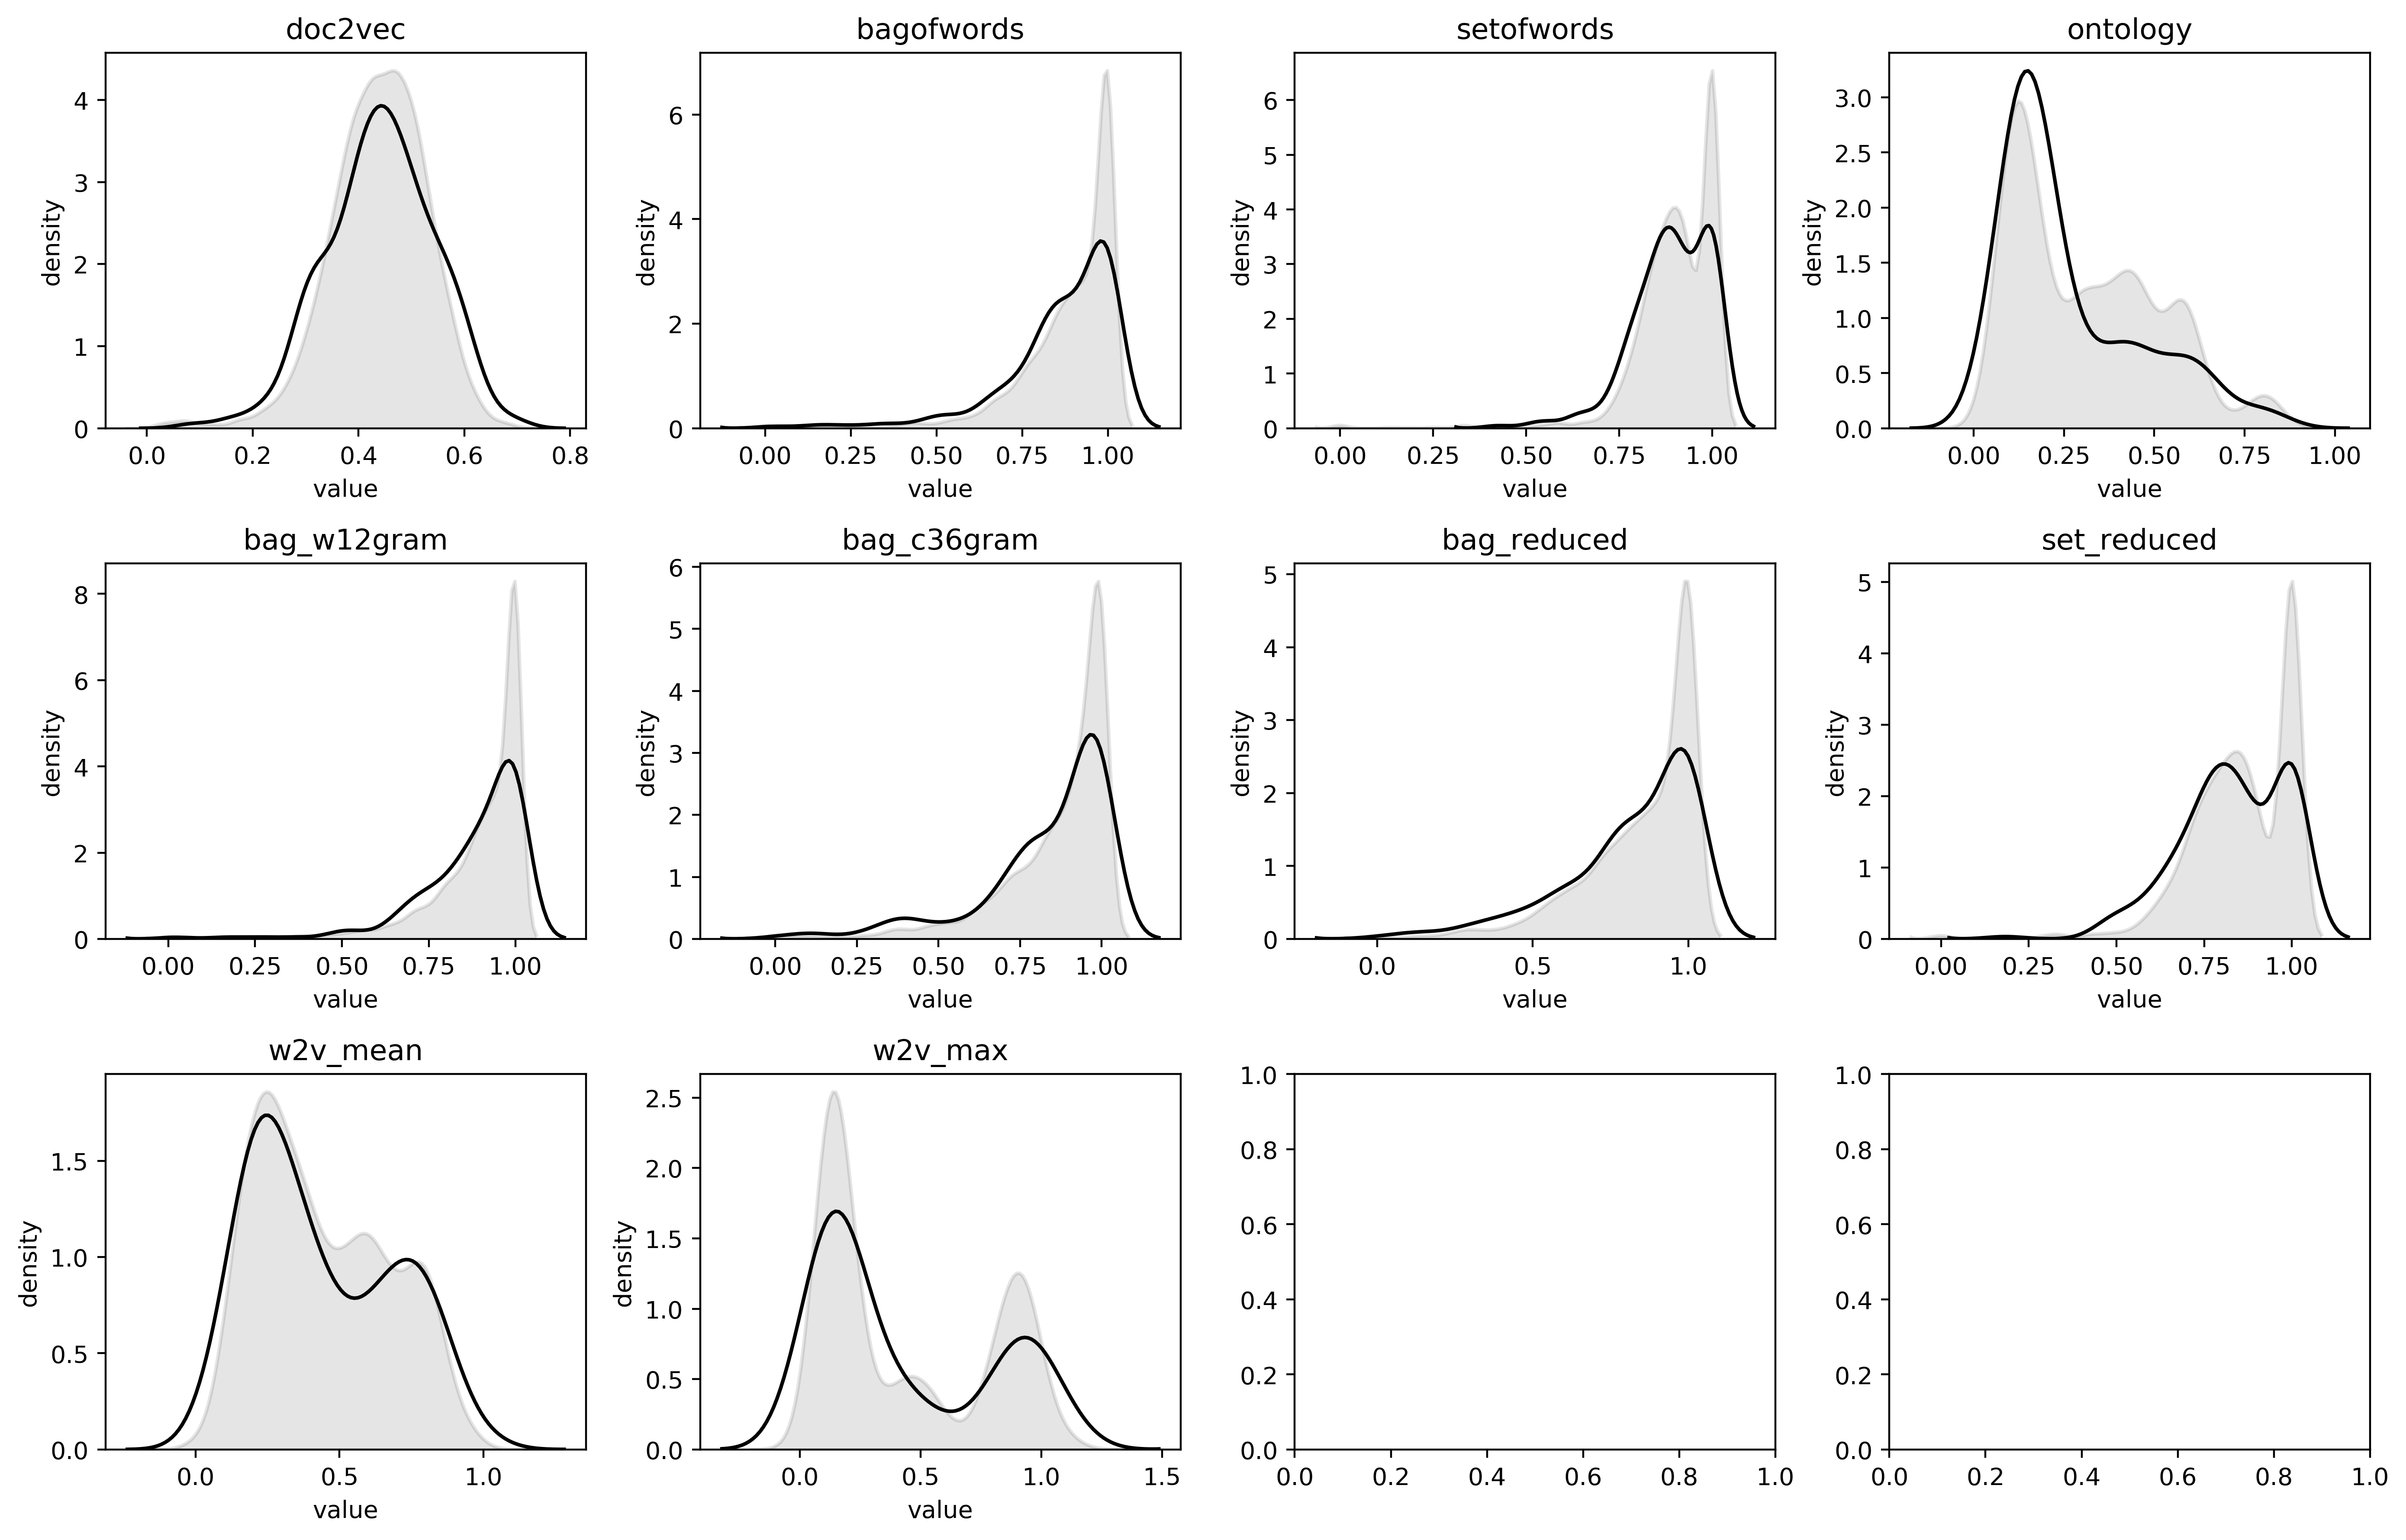

In [12]:
# Use Kolmogorov-Smirnov test to see if protein-protein interaction edges come from a distinct distribution.
ppi_pos_dict = {name:(df[df["combined_score"] > 0.00][name].values) for name in methods}
ppi_neg_dict = {name:(df[df["combined_score"] == 0.00][name].values) for name in methods}
for name in methods:
    stat,p = ks_2samp(ppi_pos_dict[name],ppi_neg_dict[name])
    pos_mean = np.average(ppi_pos_dict[name])
    neg_mean = np.average(ppi_neg_dict[name])
    pos_n = len(ppi_pos_dict[name])
    neg_n = len(ppi_neg_dict[name])
    OUTPUT[name].update({(TAG,"mean_1"):pos_mean, (TAG,"mean_0"):neg_mean, (TAG,"n_1"):pos_n, (TAG,"n_0"):neg_n})
    OUTPUT[name].update({(TAG,"ks"):stat, (TAG,"ks_pval"):p})

# Show the kernel estimates for each distribution and distribution of interaction weights for each method.
num_plots, plots_per_row, row_width, row_height = (len(methods), 4, 14, 3)
fig,axs = plt.subplots(math.ceil(num_plots/plots_per_row), plots_per_row, squeeze=False)
for name,ax in zip(methods,axs.flatten()):
    ax.set_title(name)
    ax.set_xlabel("value")
    ax.set_ylabel("density")
    sns.kdeplot(ppi_pos_dict[name], color="black", shade=False, alpha=1.0, ax=ax)
    sns.kdeplot(ppi_neg_dict[name], color="black", shade=True, alpha=0.1, ax=ax) 
fig.set_size_inches(row_width, row_height*math.ceil(num_plots/plots_per_row))
fig.tight_layout()
fig.show()

### 1.5 Are the edge weights in each network generally predictive of known protein-protein interactions?
This is a different question than above, because the false positive rate is a limiting factor in how practically useful it would be to generate predictions about real protein interactions. In the case of the statistical test above, the sample distribution could be significantly different than the whole distribution of edge values even if there are many high valued edges which look like they could come from the sample distribution. In other words, the sample distribution could be distinct because of a lack of low edge weight values, not there could still be many high edge weight values that are not positive edges in this case, which represent false positives).

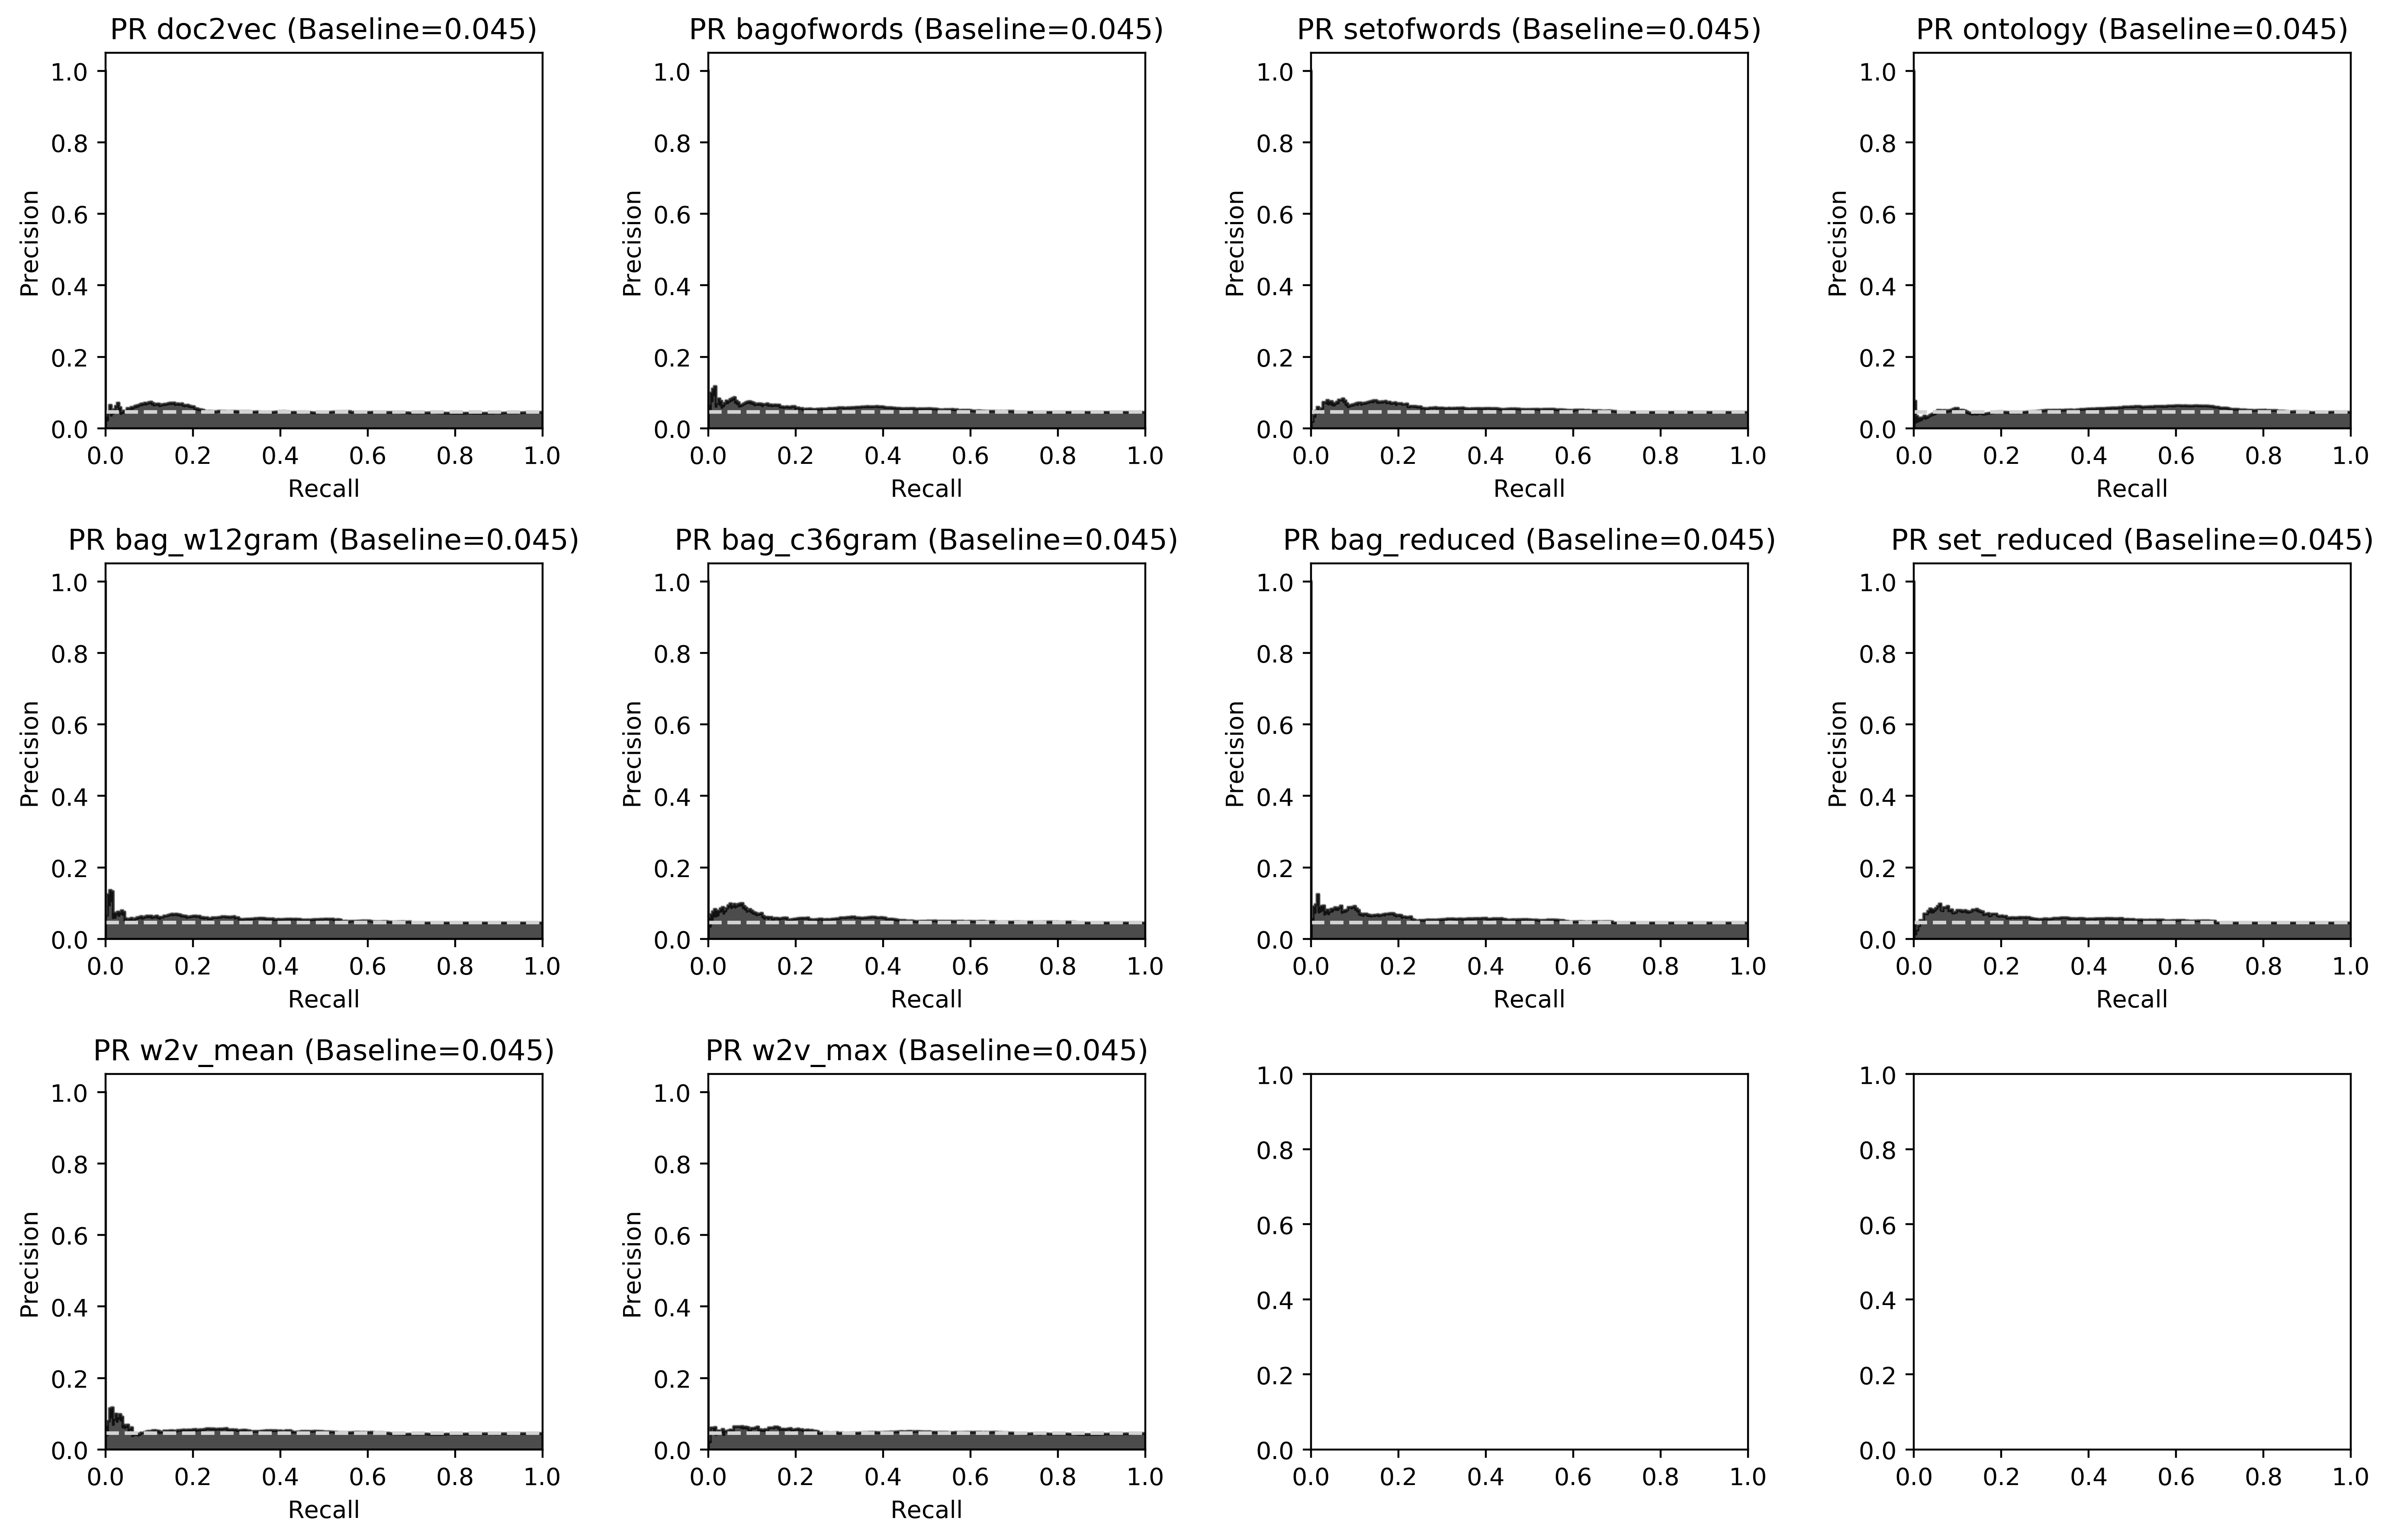

In [13]:
# Generate the targe class values, 1 indicating interaction and 0 indicating no interaction.
y_true_dict = {name:(np.where(df["combined_score"] > 0.000, 1, 0)) for name in methods}
y_prob_dict = {name:(1 - df[name].values) for name in methods}
num_plots, plots_per_row, row_width, row_height = (len(methods), 4, 14, 3)
fig,axs = plt.subplots(math.ceil(num_plots/plots_per_row), plots_per_row, squeeze=False)
for name,ax in zip(methods, axs.flatten()):
    
    # Obtaining the values and metrics.
    y_true, y_prob = y_true_dict[name], y_prob_dict[name]
    n_pos, n_neg = Counter(y_true)[1], Counter(y_true)[0]
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    baseline = Counter(y_true)[1]/len(y_true) 
    area = auc(recall, precision)
    auc_to_baseline_auc_ratio = area/baseline
    OUTPUT[name].update({(TAG,"auc"):area, (TAG,"baseline"):baseline, (TAG,"ratio"):auc_to_baseline_auc_ratio})
    
    # Producing the precision recall curve.
    step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
    ax.step(recall, precision, color='black', alpha=0.2, where='post')
    ax.fill_between(recall, precision, alpha=0.7, color='black', **step_kwargs)
    ax.axhline(baseline, linestyle="--", color="lightgray")
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title("PR {0} (Baseline={1:0.3f})".format(name, baseline))
    
fig.set_size_inches(row_width, row_height*math.ceil(num_plots/plots_per_row))
fig.tight_layout()
fig.show()

### 1.6 Are interacting partners ranked higher with respect to individual nodes?
This is a way of statistically seeing if for some value k, the graph ranks more edges from some particular gene to any other gene that it has a true protein-protein interaction with higher or equal to rank k, than we would expect due to random chance. This way of looking at the problem helps to be less ambiguous than the previous methods, because it gets at the core of how this would actually be used. In other words, we don't really care how much true information we're missing as long as we're still able to pick up some new useful information by building these networks, so even though we could be missing a lot, what's going on at the very top of the results? These results should be comparable to very strictly thresholding the network and saying that the remaining edges are our guesses at interactions. This is comparable to just looking at the far left-hand side of the precision recall curves, but just quantifies it slightly differently.

In [14]:
# Convert the undirected edgelist where an edge (j,i) is always implied by an edge (i,j) to a directed edgelist where
# both the (i,j) and (j,i) edges are explicity present in the dataframe. This is done so that we can make us of the
# groupby function to obtain all groups that contain all edges between some given node and everything its mapped to 
# by just grouping base on one of the columns specifying a node. This is easier than using a multi-indexed dataframe.
other_columns = df.columns[2:]
flipped_edges = df[flatten(["to","from",other_columns])]      # Create the flipped duplicate dataframe.
flipped_edges.columns = flatten(["from","to",other_columns])  # Rename the columns so it will stack correctly
df = pd.concat([df, flipped_edges])
df.drop_duplicates(keep="first", inplace=True)
print(df.shape)

(9938, 13)


In [15]:
k = 10 # The threshold of interest for gene ranks.
n = 1000 # Number of Monte Carlo simulation iterations to do.

# What's the number of functional partners ranked k or higher in terms of phenotypic description similarity for 
# each gene? Also figure out the maximum possible number of functional partners that could be theoretically
# recovered in this dataset if recovered means being ranked as k or higher here.
df[list(methods)] = df.groupby("from")[list(methods)].rank()
ys = df[df["combined_score"]>0.0][list(methods)].apply(lambda s: len([x for x in s if x<=k]))
ymax = sum(df.groupby("from")["combined_score"].apply(lambda s: min(len([x for x in s if x>0.00]),k)))

# Monte Carlo simulation to see what the probability is of achieving each y-value by just randomly pulling k 
# edges for each gene rather than taking the top k ones that the similarity methods specifies when ranking.
ysims = [sum(df.groupby("from")["combined_score"].apply(lambda s: len([x for x in s.sample(k) if x>0.00]))) for i in range(n)]
for method in methods:
    pvalue = len([ysim for ysim in ysims if ysim>=ys[method]])/float(n)
    OUTPUT[method][(TAG,"y")] = ys[method]
    OUTPUT[method][(TAG,"y_max")] = ymax
    OUTPUT[method][(TAG,"y_pval")] = pvalue

### 1.7 Summarizing the results for this notebook

In [16]:
results = pd.DataFrame(OUTPUT).transpose()
results

protein-protein                                                                                                   
                     mean_1    mean_0    n_1     n_0        ks       ks_pval       auc  baseline     ratio     y  y_max y_pval
doc2vec            0.440613  0.438619  226.0  4743.0  0.068643  2.491923e-01  0.048451  0.045482  1.065281  57.0  390.0  0.031
bagofwords         0.863725  0.890940  226.0  4743.0  0.108967  1.095985e-02  0.054976  0.045482  1.208748  61.0  390.0  0.004
setofwords         0.890637  0.905064  226.0  4743.0  0.095370  3.684598e-02  0.054883  0.045482  1.206687  68.0  390.0  0.000
ontology           0.263529  0.313308  226.0  4743.0  0.199659  5.190036e-08  0.051216  0.045482  1.126065  54.0  390.0  0.083
bag_w12gram        0.881339  0.904832  226.0  4743.0  0.105932  1.457375e-02  0.054466  0.045482  1.197525  63.0  390.0  0.002
bag_c36gram        0.833474  0.865846  226.0  4743.0  0.106021  1.444867e-02  0.055012  0.045482  1.209534  56.0  390.0  0.047
bag_reduced        0.815169  0.852291  226.0  4743.0  0.098605  2.802321e-02  0.056026  0.045482  1.231839  59.0  390.0  0.017
set_reduced        0.832425  0.858491  226.0  4743.0  0.109544  1.037675e-02  0.056128  0.045482  1.234081  63.0  390.0  0.002
w2v_mean           0.437841  0.443849  226.0  4743.0  0.069822  2.321584e-01  0.050317  0.045482  1.106301  65.0  390.0  0.000
w2v_max            0.422968  0.436307  226.0  4743.0  0.066324  2.854318e-01  0.048650  0.045482  1.069646  53.0  390.0  0.107